In [72]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.optim import Adam

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
datafolder = './data'
tr_fmnist = datasets.FashionMNIST(root=datafolder, download=True, train=True)
val_fmnist = datasets.FashionMNIST(root=datafolder, download=True, train=False)

tr_x = tr_fmnist.data
tr_y = tr_fmnist.targets

val_x = val_fmnist.data
val_y = val_fmnist.targets

print(tr_x.shape)
print(val_y.shape)

torch.Size([60000, 28, 28])
torch.Size([10000])


In [75]:
class FmnistDataSet(Dataset):
    def __init__(self, x, y) -> None:
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y

    def __getitem__(self, index):
        return self.x[index].to(device), self.y[index].to(device)

    def __len__(self):
        return len(self.x)

train_dataset = FmnistDataSet(tr_x, tr_y)
val_dataset = FmnistDataSet(val_x, val_y)

train_dataloader = DataLoader(train_dataset, 64, True)
val_dataloader   = DataLoader(val_dataset, 64, False)

In [76]:
class model(nn.Module):
    def __init__(self) -> None:
        super(model, self).__init__()
        self.fc1   = nn.Linear(28*28, 1000)
        self.batch_norm = nn.BatchNorm1d(1000)
        self.relu1 = nn.ReLU()
        # self.fc2   = nn.Linear(256, 32)
        # self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.batch_norm(x)
        # x = self.fc2(x)
        # x = self.relu2(x)
        x = self.fc3(x)
        return x

model      = model().to(device)
criterion   = nn.CrossEntropyLoss()
optim       = Adam(model.parameters(), lr=.001)

In [77]:
def train_batch(x, y, model, opt, loss):
    model.train()

    pred = model(x)

    l1_regularization = 0

    for param in model.parameters():
        l1_regularization += torch.norm(param, 2)

    batch_loss = loss(pred, y) + 0.0001 * l1_regularization

    batch_loss.backward()

    opt.step()

    opt.zero_grad()

    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss):
    model.eval()
    prediction = model(x)
    val_loss = loss(prediction, y)
    return val_loss.item()

In [78]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies     = [], []

for epoch in range(5):
    train_epoch_losses, train_epoch_accuracies = [], []
    for i, (x, y) in enumerate(train_dataloader):
        loss = train_batch(x, y, model, optim, criterion)
        train_epoch_losses.append(loss)
    train_epoch_losses = np.mean(train_epoch_losses)

    for i, (x, y) in enumerate(train_dataloader):
        acc = accuracy(x, y, model)
        train_epoch_accuracies.extend(acc)
    train_epoch_accuracies = np.mean(train_epoch_accuracies)

    val_epoch_loss, val_epoch_accuracy = [], []
    for i, (x, y) in enumerate(val_dataloader):
        val_epoch_accuracy.extend(accuracy(x, y, model))
        val_epoch_loss.append(val_loss(x, y, model, criterion))
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_loss     = np.mean(val_epoch_loss)

    train_losses.append(train_epoch_losses)
    train_accuracies.append(train_epoch_accuracies)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'{epoch}/5: train loss:{train_epoch_losses}, train_acc:{train_epoch_accuracies}')

0/5: train loss:0.47375534883122455, train_acc:0.85405
1/5: train loss:0.39352022270276854, train_acc:0.8705333333333334
2/5: train loss:0.368059832547138, train_acc:0.8784833333333333
3/5: train loss:0.3508195373644707, train_acc:0.8872833333333333
4/5: train loss:0.33349552632236024, train_acc:0.8872


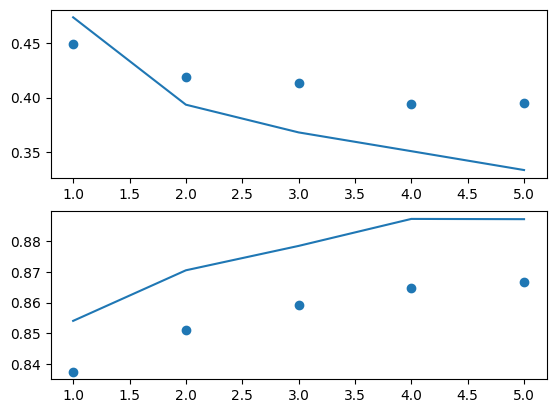

In [79]:
import matplotlib.pyplot as plt
epochs = np.arange(5)+1
fig, ax = plt.subplots(2)

# ax[0].title='training and validation loss'
ax[0].plot(epochs, train_losses)
ax[0].scatter(epochs, val_losses)
ax[1].plot(epochs, train_accuracies)
ax[1].scatter(epochs, val_accuracies)
plt.show()